In [138]:
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
import numpy as np
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u

plt.style.use(astropy_mpl_style)

In [118]:
image_file = get_pkg_data_filename('3c391_ctm_spw0_multiscale_new.fits')

In [130]:
fits.info(image_file)

Filename: 3c391_ctm_spw0_multiscale_new.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      78   (480, 480, 1, 1)   float32   


In [116]:
image_data = fits.getdata(image_file, ext=0)

In [104]:
new_image_data = image_data[0,0,:,:]

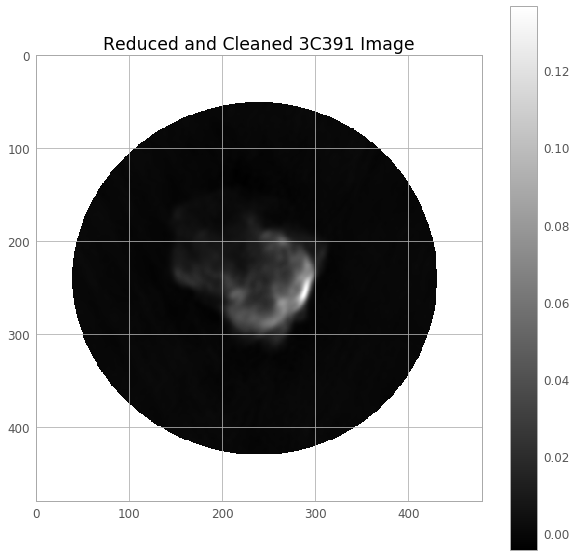

In [106]:
plt.figure(figsize = (10,10))
plt.title("Reduced and Cleaned 3C391 Image")
plt.imshow(new_image_data, cmap='gray')
plt.colorbar()

lets measure the dynamic range???? peak / noise, and asses how good of a job I did! Probably not great but I tried okay!!!

In [107]:
peak = np.nanmax(new_image_data) #in Jy I think

print("The maximum flux value of the supernova is: ", str(peak), "Jy")

The maximum flux value of the supernova is:  0.13658376 Jy


Now lets try to find an area away from the supernova that would represent the noise in the image. I chose a region in the left middle grid in the plot above.

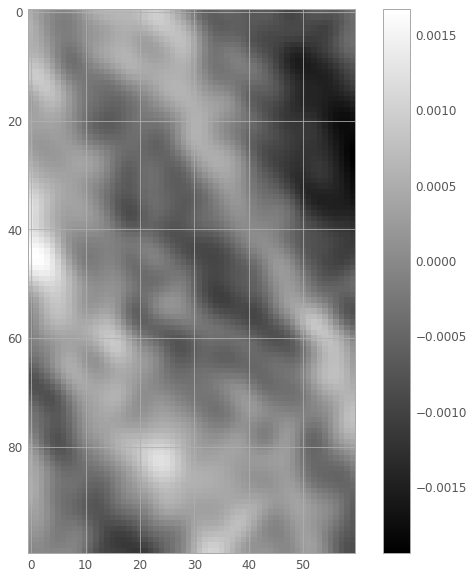

In [108]:
noise_image = new_image_data[200:300,60:120]
    
plt.figure(figsize = (10,10))
plt.imshow(noise_image, cmap='gray')
plt.colorbar()

In [109]:
noise = np.std(noise_image)

print("The typical noise value in the image is: ", str(noise), "Jy")

The typical noise value in the image is:  0.00058544043 Jy


In [110]:
DR = peak/noise

print("The typical noise value in the image is: ", DR)

The typical noise value in the image is:  233.30087


I guess that's an okay dynamic range? I think I've usually gotten sources before to like 500 or over 1000.... but those were all just bring point sources so I wonder if that's why this isnt as good? But also it just looked like the niose wasnt cleaned super well around the image, but I had a go at cleaning twice! So I'm not sure what else I could do! :/

In [111]:
centre_pix = int(480./2.)

Now let's select a region around the central point to try to get all of the supernova in there

In [172]:
x_arr = np.arange(0,480,1)
y_arr = np.arange(0,480,1)

x_pixs,y_pixs = np.meshgrid(xpixs,ypixs)

radius = 110 #pixels

cntpx_x = centre_pix - 16

cntpx_y = centre_pix-14

dist_from_centre = np.sqrt((x_pixs - cntpx_x)**2. + (y_pixs - cntpx_y)**2.)

#print(dist_from_centre)

centre_rgn_mask = dist_from_centre <= radius

masked_img = new_image_data.copy()
masked_img[~centre_rgn_mask] = np.nan
print(masked_img.shape)


(480, 480)


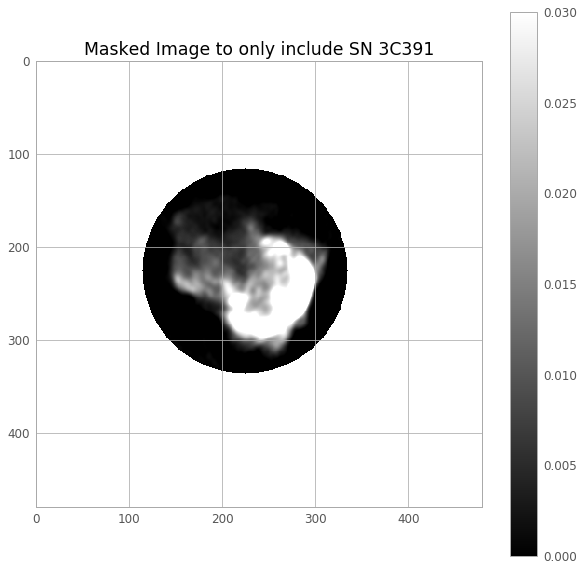

In [177]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1, 1, 1)
#ax.set_facecolor('xkcd:salmon')
plt.title("Masked Image to only include SN 3C391")
plt.imshow(masked_img, cmap='gray',vmin=0.0, vmax=0.03)
plt.colorbar()

So obviously this doesnt include *only* the SN, but like it's good enough I think... it's hard to make a perfect mask to fit this weird shape!

Now we can get the pixel scale to get an approximate diameter of the SN on the sky.
* "Historically, CDELT1 and CDELT2 have been used to indicate the plate scale in degrees per pixel" (from  http://tdc-www.harvard.edu/wcstools/wcstools.wcs.html)

In [178]:
hdu = fits.open(image_file)
#print(hdu[0].header)
header = hdu[0].header
RA_pixscale = header['CDELT1']
Dec_pixscale = header['CDELT2']

print("The RA pixel scale is: ", RA_pixscale, " degrees per pixel")

print("The Dec pixel scale is: ", Dec_pixscale, " degrees per pixel")

The RA pixel scale is:  -0.0006944444444444  degrees per pixel
The Dec pixel scale is:  0.0006944444444444  degrees per pixel


Since this is an image of equal pixels in x and y, the pixel scales are equal - makes sense.  I want to know what the radius (that I found by experimenting in a few cells above) is in sky coordinates, to get the average size of the SN to compare to the 9 arcmins that was mentioned in the tutorial.

In [179]:
radius_deg = radius*Dec_pixscale *u.deg

radius_arcmin = radius_deg.to(u.arcmin)

print("The ~radius~ of the SN remnant on the sky is: ",np.around(radius_arcmin.value), "arcmins")

The ~radius~ of the SN remnant on the sky is:  5.0 arcmins


Okay so obviously this doesnt match the 9 arcmins that was used in the tutorial, it seems like I'm missing about half of the SN in my mask. The 9 arcmins was probably taking into account a bunvh of diffuse emission that I'm not seeing because of my aspect ratio on my plots (maybe I should have looked at the colorbad with log spacing?), but that's okay 5 arcmins is the radius of the brightest emission.  I knew this wasnt going to be perfect anyway!